In [106]:
import numpy as np
import matplotlib.pyplot as plt

In [107]:
data = np.genfromtxt('single_patient_data.txt', skip_header = 1)

In [108]:
time = data[:, 0]
conc = data[:, 1]
D0 = 400 * 1e6 #400 mg -> ng
bw = 84
F = 0.6
V = 20 * bw * 1000 #milliliters

In [109]:
from numpy import exp
def conc_func(t, k_a, k_e):
    c = k_a * F * D0 / (V * (k_a - k_e)) * (exp(-k_e * t) - exp(-k_a * t))
    return c

def d_c_dk_a(t, k_a, k_e):
    c = F * D0 / V * (k_a * t / (k_a - k_e) * exp(-k_a * t) + (exp(-k_e * t) - exp(-k_a * t)) * (1 / (k_a - k_e) - k_a / ((k_a - k_e) ** 2)))
    return c

def d_c_dk_e(t, k_a, k_e):
    c = F * D0 / V * (-k_a * t / (k_a - k_e) * exp(-k_e * t) + (exp(-k_e * t) - exp(-k_a * t)) * k_a / ((k_a - k_e) ** 2))
    return c

In [110]:
def gradient(x):
    k_a = x[0]
    k_e = x[1]
    d_mse_d_k_a = 0
    d_mse_d_k_e = 0
    for i in range(0, len(time)):
        d_mse_d_k_a += (conc[i] - conc_func(time[i], k_a, k_e)) * d_c_dk_a(time[i], k_a, k_e)

        d_mse_d_k_e += (conc[i] - conc_func(time[i], k_a, k_e)) * d_c_dk_e(time[i], k_a, k_e)
    d_mse_d_k_a = -2 * d_mse_d_k_a / len(time)
    d_mse_d_k_e = -2 * d_mse_d_k_e / len(time)
    
    return np.array([d_mse_d_k_a, d_mse_d_k_e])

In [111]:
initial_guess = np.array([3, 5])
x_k = initial_guess
grad = gradient(x_k)
print(grad)

[63.94701792 55.51063574]


In [112]:
def f_of_x_plus_alpha_d(x_k, d_k, alpha):
    k_a = x_k[0] + alpha * (-d_k[0])
    k_e = x_k[1] + alpha * (-d_k[1])
    mse = 0
    for i in range(0, len(time)):
        mse += (conc[i] - conc_func(time[i], k_a, k_e)) ** 2
    return mse/len(time)

In [113]:
#to find the minimum f
def golden_sections(f, x_k, d_k, a, b):
    r = (np.sqrt(5) - 1) / 2
    x1 = (1 - r) * (b - a) + a
    x2 = (r) * (b - a) + a
    # Golden Section是為了找出最小值
    f_x1 = f(x_k, d_k, x1)
    f_x2 = f(x_k, d_k, x2)
    tolerance = 1e-9
    for i in range(0, 10000):
        if(f_x1 >= f_x2): #把a到x1部分丟掉 因為x1數值比較大 但我們要找最小值 保留x1到b部分 原x2變成新x1 x1變成a
            a = x1
            x1 = x2
            x2 = r * (b - a) + a
            f_x1 = f_x2
            f_x2 = f(x_k, d_k, x2)
        else: #丟x2到b部分
            b = x2 #a還是a
            x2 = x1
            x1 = (1 - r) * (b - a) + a
            f_x2 = f_x1
            f_x1 = f(x_k, d_k, x1)
        if(np.abs(a - b) < tolerance):
            break
    return (a + b) // 2

    print("最大值出現在(X axis)", (a + b) / 2)
    print("最大值為(Y axis)", f((a + b) / 2))

In [114]:
d_k = grad / np.linalg.norm(grad)
max_iter = 35000
alpha = golden_sections(f_of_x_plus_alpha_d, x_k, d_k, 0, 3)
tolerance = 1e-6
for i in range(0, max_iter):
    x_k = x_k - alpha * d_k 
    grad = gradient(x_k)
    grad_norm = np.linalg.norm(grad)
    if(grad_norm < tolerance):
        break
    d_k = grad / grad_norm
    print(x_k)

[1.48967304 3.68892698]
[0.23984383 2.12754075]
[2.20211383 1.74089305]
[ 1.60730097 -0.16860889]
[1.58340103 1.8312483 ]
[ 0.93422602 -0.06046304]
[0.88425379 1.93891256]
[ 0.63871689 -0.04595813]
[0.52231128 1.95065143]
[1.74134254 0.36510333]
[-0.14981323 -0.28568839]
[1.7021392  0.46947531]
[ 1.4883286  -1.51906311]
[1.39767291 0.47888122]
[ 1.22906947 -1.51399933]
[1.10867896 0.48237391]
[ 1.0822862  -1.51745193]
[0.93743917 0.47729601]
[ 1.13803397 -1.512619  ]
[1.00342967 0.48284628]
[ 1.08966744 -1.51529362]
[0.9462946  0.47956082]
[ 1.1258191  -1.51236562]
[0.98911046 0.48295659]
[ 1.09486416 -1.51424549]
[0.95250048 0.48068122]
[ 1.11900842 -1.5123755 ]
[0.98109891 0.48286408]
[ 1.09855442 -1.513684  ]
[0.95689487 0.48129284]
[ 1.11484763 -1.51246014]
[0.97619375 0.48272785]
[ 1.10115693 -1.51336438]
[0.95998827 0.48164725]
[ 1.11219442 -1.51255266]
[0.97306133 0.48260196]
[ 1.10297569 -1.51317414]
[0.96214747 0.48186155]
[ 1.11046262 -1.51263152]
[0.97101474 0.48250113]
[ 1.

Text(0, 0.5, 'Concentration')

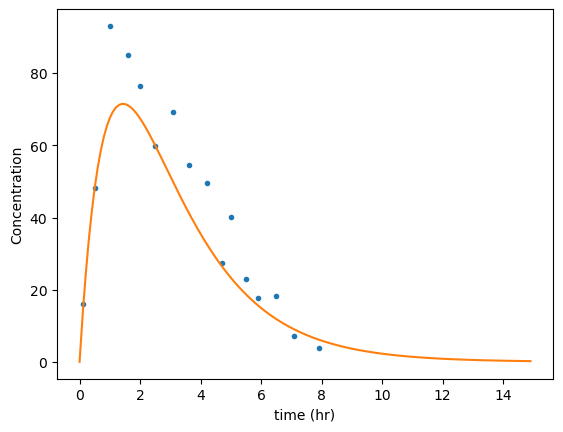

In [115]:
time_plot = np.arange(0, len(time)-1, 0.1)
plt.figure(1)
plt.plot(time, conc, '.')
plt.plot(time_plot, conc_func(time_plot, x_k[0], x_k[1]))
plt.xlabel('time (hr)')
plt.ylabel('Concentration')